# Titanic

## Import packages

In [1]:
import pandas as pd
import numpy as np

import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN
import xgboost as xgb

from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt

import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization

import plotly.graph_objs as go#visualization


%matplotlib inline

/opt/miniconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Load dataset

In [2]:
df_train = pd.read_csv("train.csv")
print(df_train.shape)
df_train.head(5)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
survived = df_train[df_train["Survived"] == 1]
not_survived = df_train[df_train["Survived"] == 0]

In [4]:
df_test = pd.read_csv("test.csv")
print(df_test.shape)
df_test.head(5)

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
features = [
    "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"
]
cat_cols = [
    "Pclass", "Sex", "Embarked"
]
num_cols = [
    "Age", "SibSp", "Parch", "Fare"
]
target = "Survived"
key = "PassengerId"

## Exploration

### Survivals

In [6]:
#labels
lab = df_train[target].value_counts().keys().tolist()
#values
val = df_train[target].value_counts().values.tolist()

trace = go.Pie(labels = lab, values = val ,
               marker = dict(colors =  [ 'royalblue' ,'lime'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Survivals in data",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)

### Variables distribution in survival

In [7]:
def plot_pie(df, column) :
    
    survived = df[df[target] == 1]
    not_survived = df[df[target] == 0]

    trace1 = go.Pie(values  = survived[column].value_counts().values.tolist(),
                    labels  = survived[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Survival",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .6
                   )
    
    trace2 = go.Pie(values  = not_survived[column].value_counts().values.tolist(),
                    labels  = not_survived[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "No survival" 
                   )
    
    layout = go.Layout(dict(title = column + " distribution in survival ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "Survivals",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "No survival",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .88,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)

In [8]:
def histogram(df, column) :
    
    survived = df[df[target] == 1]
    not_survived = df[df[target] == 0]
    
    trace1 = go.Histogram(x  = survived[column],
                          histnorm= "percent",
                          name = "Survival",
                          marker = dict(line = dict(width = .5,
                                                    color = "black"
                                                    )
                                        ),
                         opacity = .9 
                         ) 
    trace2 = go.Histogram(x  = not_survived[column],
                          histnorm = "percent",
                          name = "No survival",
                          marker = dict(line = dict(width = .5,
                                              color = "black"
                                             )
                                 ),
                          opacity = .9
                         )
    data = [trace1,trace2]
    layout = go.Layout(dict(title =column + " distribution in survival ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                         zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                           )
                      )
    fig  = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)

In [9]:
#for all categorical columns plot pie
for i in cat_cols :
    plot_pie(df_train, i)
    
#for all categorical columns plot histogram    
for i in num_cols :
    histogram(df_train, i)

## Features engineering

### Missing values

In [10]:
df_train.isnull().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Categorization

In [12]:
pd.qcut(df_train["Age"], 4).unique()

[(20.125, 28.0], (28.0, 38.0], NaN, (38.0, 80.0], (0.419, 20.125]]
Categories (4, interval[float64]): [(0.419, 20.125] < (20.125, 28.0] < (28.0, 38.0] < (38.0, 80.0]]

In [13]:
def build_age_group(df):
    df.loc[df["Age"].isnull(), "age_group"] = "missing"
    df.loc[df["Age"] < 20, "age_group"] = "-20"
    df.loc[(df["Age"] >= 20) & (df["Age"] < 28), "age_group"] = "20-28"
    df.loc[(df["Age"] >= 28) & (df["Age"] < 38), "age_group"] = "28-38"
    df.loc[(df["Age"] >= 38) & (df["Age"] < 80), "age_group"] = "38-80"
    df.loc[(df["Age"] >= 80), "age_group"] = "80+"

In [14]:
build_age_group(df_train)
build_age_group(df_test)

In [15]:
plot_pie(df_train, "age_group")

In [16]:
features.append("age_group")

### Family size

In [17]:
def get_family_size(df):
    df["FamilySize"] = df["SibSp"] + df["Parch"]

In [18]:
get_family_size(df_train)
get_family_size(df_test)

In [19]:
features.append("FamilySize")

### Is Alone

In [20]:
def is_alone(df):
    df["IsAlone"] = 1
    df.loc[df["FamilySize"] > 0, "IsAlone"] = 0

In [21]:
is_alone(df_train)
is_alone(df_test)

In [22]:
features.append("IsAlone")

## Title

In [23]:
def get_title(df):
    df["IsMiss"] = df["Name"].str.contains("Miss\.|Mlle\.")
    df["IsMisses"] = df["Name"].str.contains("Mrs\.|Mme\.")
    df["IsMr"] = df["Name"].str.contains("Mr\.")
    df["IsMaster"] = df["Name"].str.contains("Master\.")
    df["IsReverant"] = df["Name"].str.contains("Rev\.")
    df["IsDoctor"] = df["Name"].str.contains("Dr\.")
    df["IsMilitarian"] = df["Name"].str.contains("Col\.|Major\.|Capt\.")
    
    df["NameLength"] = df["Name"].str.len()

In [24]:
get_title(df_train)
get_title(df_test)

In [25]:
features += ["IsMiss", "IsMisses", "IsMr", "IsMaster", "IsReverant", "IsDoctor", "IsMilitarian", "NameLength"]

### Cabin

In [26]:
df_train["HasCabin"] = 1
df_train.loc[df_train["Cabin"].isnull(), "HasCabin"] = 0

In [27]:
df_test["HasCabin"] = 1
df_test.loc[df_test["Cabin"].isnull(), "HasCabin"] = 0

In [28]:
features.append("HasCabin")

### Variables binaires

In [29]:
df = pd.concat([df_train, df_test], axis=0)
df["Pclass"] = df["Pclass"].astype(str)
print(df.shape)

(1309, 24)


In [30]:
df_features = pd.get_dummies(df[features])
print(df_features.head(5))

    Age  SibSp  Parch     Fare  FamilySize  IsAlone  IsMiss  IsMisses   IsMr  \
0  22.0      1      0   7.2500           1        0   False     False   True   
1  38.0      1      0  71.2833           1        0   False      True  False   
2  26.0      0      0   7.9250           0        1    True     False  False   
3  35.0      1      0  53.1000           1        0   False      True  False   
4  35.0      0      0   8.0500           0        1   False     False   True   

   IsMaster        ...          Sex_male  Embarked_C  Embarked_Q  Embarked_S  \
0     False        ...                 1           0           0           1   
1     False        ...                 0           1           0           0   
2     False        ...                 0           0           0           1   
3     False        ...                 0           0           0           1   
4     False        ...                 1           0           0           1   

   age_group_-20  age_group_20-28  age

In [31]:
training_set = df_features.iloc[df_train.index]
training_set[target] = df_train[target]
print(training_set.shape)
training_set.head(5)

(891, 30)


/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Age,SibSp,Parch,Fare,FamilySize,IsAlone,IsMiss,IsMisses,IsMr,IsMaster,...,Embarked_C,Embarked_Q,Embarked_S,age_group_-20,age_group_20-28,age_group_28-38,age_group_38-80,age_group_80+,age_group_missing,Survived
0,22.0,1,0,7.2500,1,0,False,False,True,False,...,0,0,1,0,1,0,0,0,0,0
1,38.0,1,0,71.2833,1,0,False,True,False,False,...,1,0,0,0,0,0,1,0,0,1
2,26.0,0,0,7.9250,0,1,True,False,False,False,...,0,0,1,0,1,0,0,0,0,1
3,35.0,1,0,53.1000,1,0,False,True,False,False,...,0,0,1,0,0,1,0,0,0,1
4,35.0,0,0,8.0500,0,1,False,False,True,False,...,0,0,1,0,0,1,0,0,0,0


In [32]:
test_set = df_features.iloc[len(df_train):]
print(test_set.shape)
test_set.head(5)

(418, 29)


,Age,SibSp,Parch,Fare,FamilySize,IsAlone,IsMiss,IsMisses,IsMr,IsMaster,...,Sex_male,Embarked_C,Embarked_Q,Embarked_S,age_group_-20,age_group_20-28,age_group_28-38,age_group_38-80,age_group_80+,age_group_missing
0,34.5,0,0,7.8292,0,1,False,False,True,False,...,1,0,1,0,0,0,1,0,0,0
1,47.0,1,0,7.0000,1,0,False,True,False,False,...,0,0,0,1,0,0,0,1,0,0
2,62.0,0,0,9.6875,0,1,False,False,True,False,...,1,0,1,0,0,0,0,1,0,0
3,27.0,0,0,8.6625,0,1,False,False,True,False,...,1,0,0,1,0,1,0,0,0,0
4,22.0,1,1,12.2875,2,0,False,True,False,False,...,0,0,0,1,0,1,0,0,0,0


In [33]:
features = test_set.columns.tolist()
features.remove("Age")
features

['SibSp',
 'Parch',
 'Fare',
 'FamilySize',
 'IsAlone',
 'IsMiss',
 'IsMisses',
 'IsMr',
 'IsMaster',
 'IsReverant',
 'IsDoctor',
 'IsMilitarian',
 'NameLength',
 'HasCabin',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'age_group_-20',
 'age_group_20-28',
 'age_group_28-38',
 'age_group_38-80',
 'age_group_80+',
 'age_group_missing']

In [34]:
continous_features = ['SibSp', 'Parch', 'Fare',
                      #"Age",
                      "NameLength", "FamilySize"]
categorical_features = [
    'Pclass_1', 'Pclass_2', 'Pclass_3',
    'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
    
    'age_group_-20',
    'age_group_20-28',
    'age_group_28-38',
    'age_group_38-80',
    'age_group_80+',
    'age_group_missing',
    
    'IsMiss',
    'IsMisses',
    'IsMr',
    'IsMaster',
    'IsReverant',
    'IsDoctor',
    'IsMilitarian',
    'IsMiss',
    'IsMisses',
    'IsMr',
    'IsMaster',
    'IsReverant',
    'IsDoctor',
    'IsMilitarian',
    "HasCabin",
    "IsAlone"
]

## Modelisation

### Learning and evaluation

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    training_set[features], training_set[target], test_size=0.33, random_state=42
)

#### Variable selection

In [97]:
def information_value(X, y):
    """
    Compute the information value of a categorical variable for a binary variable to predict.
    Information value of a categorical variable has the following power prediction meaning:

        < 0.02 useless for prediction

        0.02 to 0.1 week predictor

        0.1 to 0.3 medium predictor

        0.3 to 0.5 strong predictor

        > 0.5 suspicious or to good to be true

    Args:
        X: a pandas serie representing a categorical variable
        y: a pandas serie representing a binary variable to predict

    Returns:
        a boolean meaning the variable is explainable or not in regard of the threshold
    """
    X = pd.Series(X)
    y = pd.Series(y)

    K = sorted(X.unique())
    classes = [0, 1]

    iv = []
    for k in K:
        dist_good = float((y[X == k] == classes[1]).sum()) / (y == classes[1]).sum()
        dist_bad = float((y[X == k] == classes[0]).sum()) / (y == classes[0]).sum()
        iv.append((dist_bad - dist_good) * np.log(float(dist_bad) / dist_good))
    return sum(iv)

In [98]:
def fisher_score(X, y):
    """
    Compute the fisher score of a continuous variable for a binary variable to predict.

    Args:
        X: a pandas serie representing a continuous variable
        y: a pandas serie representing a binary variable to predict

    Returns:
        the fisher score of the variable
    """
    classes = y.unique()
    return abs(X[y == classes[1]].mean() - X[y == classes[0]].mean()) / \
           np.sqrt(X[y == classes[1]].var() + X[y == classes[0]].var())

In [99]:
def filter_correlated_variables(df, features_name, threshold=0.9):
    """
    filter variable from data set which overpass a correlation threshold.

    Args:
        df: a pandas dataframe data set
        features_name: a list of variable names
        threshold: the correlation threshold from which variables are filtered
    Returns:
        the features name filtered
    """
    features_to_keep = set(features_name)

    corr = df[features_name].corr(method="pearson").abs()
    for f1 in features_name:
        for f2 in features_name:
            if f1 != f2 and corr.loc[f1, f2] > threshold and f2 in features_to_keep and f1 in features_to_keep:
                print("%s is too much correlated to %s" % (f2, f1))
                features_to_keep.remove(f2)
    return list(features_to_keep)

In [101]:
iv = {feature: information_value(X_train[feature], y_train) for feature in categorical_features}
sorted_iv = sorted(iv.items(), key=lambda kv: -kv[1])
cat_features = [k for k, v in sorted_iv]
sorted_iv

/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning:

divide by zero encountered in log

/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning:

divide by zero encountered in double_scalars



[('age_group_80+', inf),
 ('IsReverant', inf),
 ('IsMr', 1.2664160014864616),
 ('Sex_female', 1.260254603709734),
 ('Sex_male', 1.260254603709734),
 ('IsMisses', 0.5637588555479243),
 ('Pclass_3', 0.41725344378400175),
 ('HasCabin', 0.39945387557753564),
 ('IsMiss', 0.3939704700745357),
 ('Pclass_1', 0.2525612832997139),
 ('Embarked_C', 0.149371132936002),
 ('IsAlone', 0.12438793223288516),
 ('Embarked_S', 0.12181761715868358),
 ('age_group_missing', 0.06787203278777544),
 ('Pclass_2', 0.0629330814512191),
 ('age_group_-20', 0.01947248427148626),
 ('IsMaster', 0.01770249132034276),
 ('age_group_28-38', 0.007345984093341508),
 ('IsDoctor', 0.0020418087254046938),
 ('age_group_20-28', 0.00153885832916397),
 ('age_group_38-80', 0.000662321485713802),
 ('IsMilitarian', 0.00014536206998023085),
 ('Embarked_Q', 4.236259771827187e-05)]

In [40]:
fisher_score(X_train[continous_features], y_train).sort_values()

FamilySize    0.009787
SibSp         0.084367
Parch         0.102033
Fare          0.322825
NameLength    0.416832
dtype: float64

In [41]:
features = cat_features + continous_features
features = filter_correlated_variables(X_train, features, threshold=0.9)
print()
print(features)
print()
print(len(features))

Sex_male is too much correlated to Sex_female
FamilySize is too much correlated to SibSp

['IsAlone', 'IsMilitarian', 'Pclass_3', 'age_group_28-38', 'Pclass_2', 'IsMiss', 'IsMr', 'Fare', 'age_group_20-28', 'Parch', 'age_group_-20', 'age_group_missing', 'Pclass_1', 'NameLength', 'SibSp', 'IsMisses', 'IsDoctor', 'Embarked_S', 'Embarked_C', 'IsReverant', 'age_group_38-80', 'age_group_80+', 'IsMaster', 'Embarked_Q', 'HasCabin', 'Sex_female']

26


#### Over sampling technique

In [42]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

#### Learning

In [43]:
dtrain = xgb.DMatrix(X_resampled, y_resampled)
dtest = xgb.DMatrix(X_test.values, y_test.values)

param = {
    'n_estimators': 100, 'max_depth': 3, 'eta': 0.6, 'subsample': 0.3,
    'min_child_weight': 2, 'gamma': 0.9,        
    'silent':1, 'objective': 'binary:logistic'
}
num_round = 5

bst = xgb.train(param, dtrain, num_round)

#### Test

In [44]:
y_score = bst.predict(dtest)

In [45]:
y_probas = np.zeros((y_score.shape[0], 2))
y_probas[:, 1] = y_score
y_probas[:, 0] = 1 - y_score

In [46]:
fpr = dict()
tpr = dict()
precision = dict()
recall = dict()
thresholds = dict()
f_score = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_test, y_score)
    f_score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [47]:
accuracy = dict()
accuracy[0] = np.zeros((thresholds[0].shape))
for i,threshold in enumerate(thresholds[0]):
    y_pred = np.where(y_score > threshold, 1, 0)
    accuracy[0][i] = accuracy_score(y_test, y_pred)

In [48]:
best_threshold = thresholds[0][np.argmax(accuracy[0][:-1])]
print("Threshold maximising the accuracy score: %.2f" % best_threshold)

Threshold maximising the accuracy score: 0.63


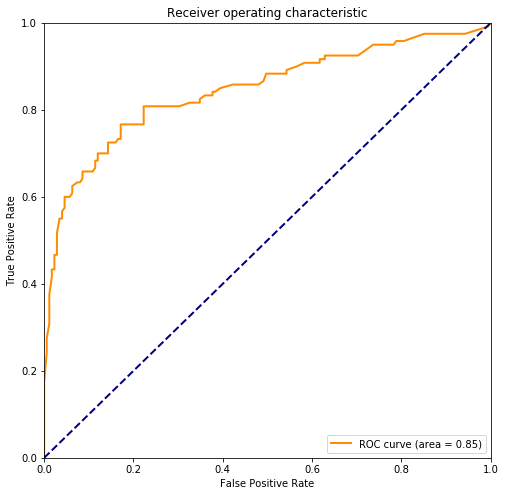

In [49]:
plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

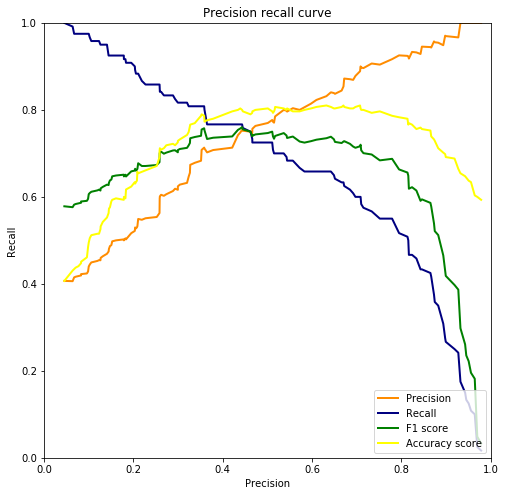

In [50]:
plt.figure(figsize=(8,8))
lw = 2
plt.plot(thresholds[0], precision[0][:-1], color='darkorange', lw=lw, label='Precision')
plt.plot(thresholds[0], recall[0][:-1], color='navy', lw=lw, label='Recall')
plt.plot(thresholds[0], f_score[0][:-1], color="green", lw=lw, label="F1 score")
plt.plot(thresholds[0], accuracy[0], color="yellow", lw=lw, label="Accuracy score")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision recall curve')
plt.legend(loc="lower right")
plt.show()

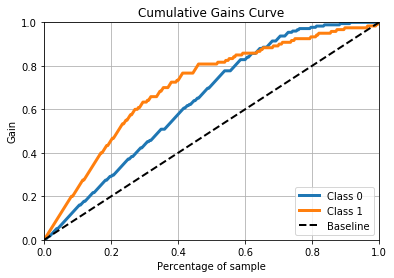

In [51]:
skplt.metrics.plot_cumulative_gain(y_test, y_probas)

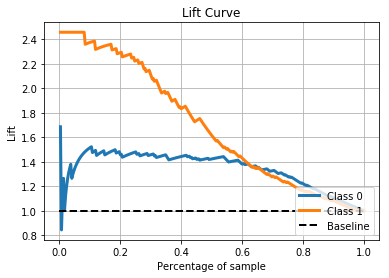

In [52]:
skplt.metrics.plot_lift_curve(y_test, y_probas)

## Submission

In [53]:
X_resampled, y_resampled = SMOTE().fit_resample(training_set[features].values, training_set[target].values)

In [54]:
dtrain = xgb.DMatrix(X_resampled, y_resampled)
dtest = xgb.DMatrix(test_set[features].values)

bst = xgb.train(param, dtrain, num_round)

In [55]:
y_score = bst.predict(dtest)

In [56]:
y_pred = np.where(y_score > best_threshold, 1, 0)

In [57]:
submission = pd.concat([df_test[key], pd.Series(y_pred, name="Survived")], axis=1)

In [58]:
submission.to_csv("submission.csv", index=None)